# `gpytorch`

Examples of using the `gpytorch` package for Gaussian Processes in PyTorch.
Documention for the package can be found [here](https://github.com/cornellius-gp/gpytorch).

In [1]:
%matplotlib inline
%colors linux
%load_ext autoreload
%autoreload 2

## Regression Tutorial

This tutorial is an example from the `gpytorch` documentation.
The original can be found [here](https://github.com/cornellius-gp/gpytorch/blob/master/examples/01_Simple_GP_Regression/Simple_GP_Regression.ipynb)

In this example, the features of `gpytorch` will be illustrated within the context of a simple regression problem.
Here we will train a Radial Basis Function (RBF) Kernel Gaussian Process to model

$$
\begin{align}
    y &= \sin(2 \pi x) + \varepsilon \\
    \varepsilon &\sim \mathcal{N}(0, 0.2)
\end{align}
$$

We will have $11$ training examples, and evaluate the performance on $51$ test examples.

In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

In the next cell we will set up the training data for the example.
We'll be using 11 regularly spaced points in $[0, 1]$ which we evaluate the fucntion on and add Gaussian noise to get the training labels.

In [3]:
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2 

Unlike other Gaussian Process packages, `gpytorch` does not provide a full Gaussian Process model, but instead provides tools to quickly construct one.
This design philosophy is inline with `pytorch`, preferring flexibility to include whatever components are necessary (such as Deep Kernel Learning).

For most __Gaussian Process__ models you will need the following `gpytorch` objects:

1. A __Gaussian Process Model__ - `gpytorch.models.ExactGP` - This handles most of the inference
2. A __Likelihood__ - `gpytorch.likelihoods.GaussianLikelihood` - THis is the most common likelihood used for __GP__ regression
3. A __Mean__ - Defines the prior mean for the __Gaussian Process__
    - If you don't know which to use, `gpytorch.means.ConstantMean()` is a good place to start.
4. A __Kernel__ - Defines the prior covariance of the __GP__
    - If you don't know which to use, `gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())` is a good first choice.
5. A __Multivariate Normal Distribution__ - `gpytorch.distributions.MultivariateNormal` - This is the object used to represent multivariate normal distributions

Similar to `pytorch`, a user defined __Gaussian Process__ will include an `__init__` method, as well as a `forward` method.
The forward method takes in $n \times d$ data `x`, and returns an instance of a `gpytorch.distributions.MultivariateNormal` object with the _prior_ mean and covariance matrix evaluated at `x`.

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

Like `pytorch`, `ExactGP` (the parent of our user-defined `ExactGPModel`) has `.train()` and `.eval()` settings.

## Training

To train the model, we use Type-II MLE to train the hyperparameters of the __Gaussian Process__.

With `gpytorch`, we define a training loop similar to `torch`.
The standard `torch` optimizers from `torch.optim`, and all trainable parameters for your model should be of the type `torch.nn.Parameter`.

More often than not the boilerplate code here will work well.
It has the same basic components of a training loop for a standard `torch` model.

1. Zero all parameter gradients
2. Call the model and compute the loss
3. Call `.backward()` on the loss to fill gradients
4. Take a step on the optimizer

However, defining custom training loops allows for greater flexibility.
For example, it is easy to save the parameters at each step of training, or use heterogeneous learning-rates for different parameters (useful for Deep Kernel Learning).

### Initiate training mode

In [6]:
model.train()
likelihood.train();

### Instatiate the optimizer

In [7]:
optimizer = torch.optim.Adam(
    [{'params': model.parameters()}],  # includes the GaussianLikelihood parameters (see model.__init__()) 
    lr=0.1,
)

### Instantiate Loss

In [8]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

### Define training loop

In [9]:
n = 50  # number of iterations
pbar = tqdm(range(n))  

for i in pbar:
    optimizer.zero_grad()  # zero gradients
    
    output = model(train_x)  # forward pass on the data
    
    loss = -mll(output, train_y)
    loss.backward()  # back propagation
    
    log_lengthscale = model.covar_module.base_kernel.log_lengthscale.item()
    log_noise = model.likelihood.log_noise.item()
    
    print(
        f"{i+1:3}/{n} | Loss: {loss.item(): .2f}, log_lengthscale: {log_lengthscale: .2f}, log_noise: {log_noise: .2f}"
    )
    
    optimizer.step()
    

  1/50 | Loss:  1.09, log_lengthscale:  0.00, log_noise:  0.00
  2/50 | Loss:  1.05, log_lengthscale: -0.10, log_noise: -0.10
  3/50 | Loss:  1.01, log_lengthscale: -0.20, log_noise: -0.20
  4/50 | Loss:  0.97, log_lengthscale: -0.29, log_noise: -0.30
  5/50 | Loss:  0.93, log_lengthscale: -0.38, log_noise: -0.40
  6/50 | Loss:  0.89, log_lengthscale: -0.47, log_noise: -0.50
  7/50 | Loss:  0.84, log_lengthscale: -0.56, log_noise: -0.60
  8/50 | Loss:  0.78, log_lengthscale: -0.65, log_noise: -0.70
  9/50 | Loss:  0.72, log_lengthscale: -0.74, log_noise: -0.80
 10/50 | Loss:  0.65, log_lengthscale: -0.84, log_noise: -0.90
 11/50 | Loss:  0.59, log_lengthscale: -0.93, log_noise: -1.00
 12/50 | Loss:  0.54, log_lengthscale: -1.03, log_noise: -1.10
 13/50 | Loss:  0.50, log_lengthscale: -1.12, log_noise: -1.20
 14/50 | Loss:  0.46, log_lengthscale: -1.20, log_noise: -1.31
 15/50 | Loss:  0.42, log_lengthscale: -1.28, log_noise: -1.41
 16/50 | Loss:  0.38, log_lengthscale: -1.34, log_noise

## Inference

As stated above, a `gpytorch` model returns a `MultivariateNormal` object containing the prior mean and covariance from the `.forward()` method.
With these, we can sample fucntions from the __GP__ at the given test points with calls like:

### Generating Predictions

In [10]:
model.eval()  # set model and likelihood to eval mode
likelihood.eval()

with torch.no_grad():
    test_x = torch.linspace(0, 2, 101)
    observed_pred = likelihood(model(test_x))

Below the `gpytorch.fast_pred_var` context previews how to generate faster predictive distributions using [LOVE](https://arxiv.org/abs/1803.06058).

### Speedtest

#### Standard

In [11]:
%%timeit
with torch.no_grad(): 
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

7.06 ms ± 317 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### With `gpytorch.fast_pred_var()`

In [12]:
%%timeit
with torch.no_grad(), gpytorch.fast_pred_var(): 
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

1.14 ms ± 9.01 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Plot model fit

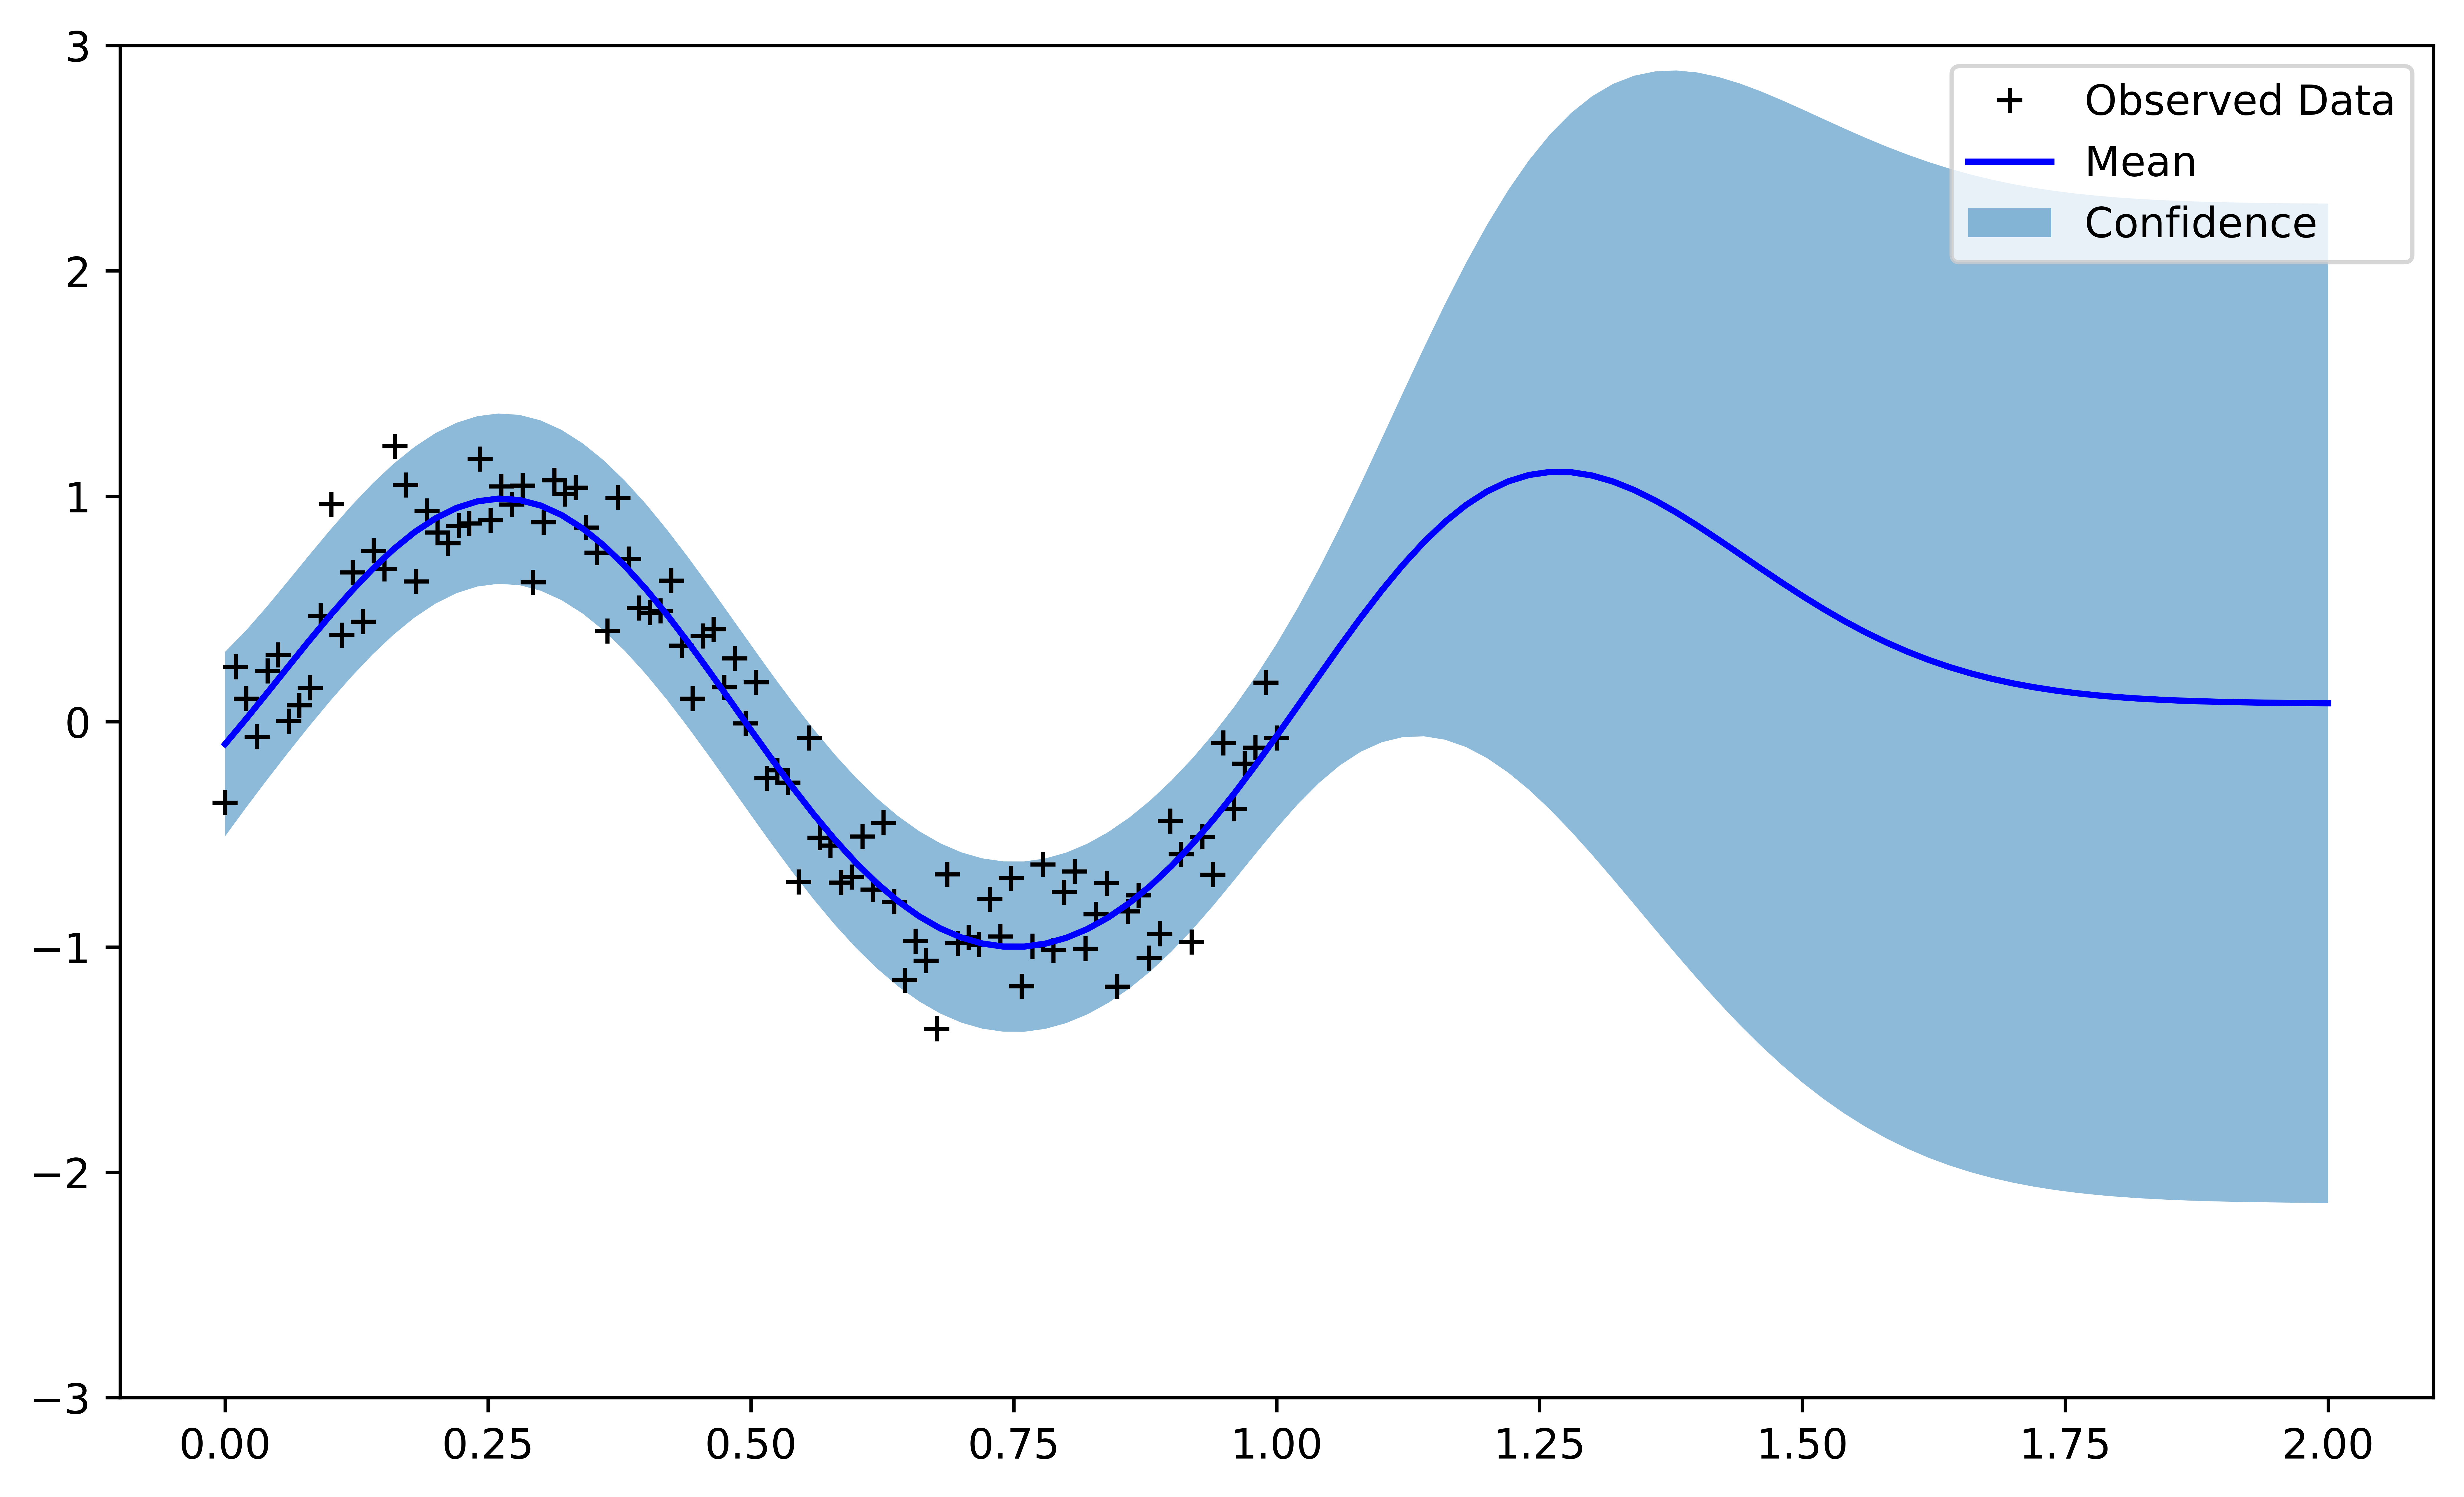

In [13]:
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=1024)
    lower, upper = observed_pred.confidence_region()  # helper for +/- 2 standard deviations
    ax.plot(train_x.numpy(), train_y.numpy(), 'k+')
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [14]:
with torch.no_grad():
    x_test = torch.tensor([3.])
    pred = likelihood(model(x_test))
    
print(f"Prediction: f({x_test.numpy()[0]: .2f}) = {pred.mean.numpy()[0]: .2f}")

Prediction: f( 3.00) =  0.08
